In [18]:
# this cell is just auto formatting so I can be lazy and still have pretty code
#!pip install black[jupyter]

# from google.colab import drive
# drive.mount("/content/drive")

#!black /content/drive/MyDrive/'Colab Notebooks'/'DATA602_HW2.ipynb'

reformatted /content/drive/MyDrive/Colab Notebooks/DATA602_HW2.ipynb

All done! ✨ 🍰 ✨
1 file reformatted.


In [ ]:
# Uploading my google drive so I can pull in the sqlite file from my drive
from google.colab import drive
drive.mount("/content/drive")

In [7]:
# This is the demo code given to us but also it goes ahead and pulls the file in
import sqlite3
import pandas as pd
import numpy as np

sqlite_file = "/content/drive/My Drive/lahman_1871-2022.sqlite"
conn = sqlite3.connect(sqlite_file)

salary_query = """SELECT yearID, sum(salary) as total_payroll
FROM Salaries WHERE lgID == 'AL' GROUP BY yearID"""

team_salaries = pd.read_sql(salary_query, conn)
team_salaries.head()

,yearID,total_payroll
0,1985,134401120.0
1,1986,157716444.0
2,1987,136088747.0
3,1988,157049812.0
4,1989,188771688.0


In [8]:
# Problem 1
# Using SQL compute a relation containing the total payroll and winning percentage
# (number of wins / number of games * 100) for each team
# (that is, for each teamID and yearID combination). You should include other columns
# that will help when performing EDA later on
# (e.g., franchise ids, number of wins, number of games).
# Include the SQL code you used to create this relation in your writeup.
# Describe how you dealt with any missing data in these two relations.
# Specifically, indicate if there is missing data in either table, and how the
# type of join you used determines how you dealt with this missing data.
# One note, for SQL you have to be mindful of integer vs. float division.


# what all tables it here in our data?
""" commented out as not to clutter the output but reserved to show my work
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
for table in tables:
    print(f"Table: {table[0]}")
    cursor.execute(f"PRAGMA table_info({table[0]})")
    columns = cursor.fetchall()
    for column in columns:
        print(column)
    print("\n")
"""

# I don't like the scientific showing of the total payroll so I'm adjusting
# the way pandas outputs large numbers
pd.set_option("display.float_format", lambda x: "%.2f" % x)

# looks like the teams table might have the teamID and W for Win and L for Loss?
# yes. data dictionary is https://cran.r-project.org/web/packages/Lahman/Lahman.pdf
# and on page 57 it mentions that W is Wins and L is Losses
"""commented out as not to clutter the output but reserved to show my work
teams_query = "select teamID, sum(W) Wins, sum(L) as Losses from Teams group by teamID"
team_wl = pd.read_sql(teams_query, conn)
print(team_wl.head())
"""
# is there any salaries without a teamID? No
"""commented out as not to clutter the output but reserved to show my work
sal_chk_query = "select * from Salaries where teamID is null"
sal_chk = pd.read_sql(sal_chk_query, conn)
print(sal_chk.head())
"""

# how many teamID's is there in Salaries? 35
"""commented out as not to clutter the output but reserved to show my work
sal_chk_query = "select count(distinct teamID) as cnt from Salaries"
sal_chk = pd.read_sql(sal_chk_query, conn)
print(sal_chk.head())
"""

# is there any datapoints from Teams  where teamID is null? No
"""commented out as not to clutter the output but reserved to show my work
teams_chk_query = "select * from Teams where teamID is null"
teams_chk = pd.read_sql(teams_chk_query, conn)
print(teams_chk.head())
"""

# how many teamID's is there in Teams? 149 so We have way
#more teams than we have salaries
"""commented out as not to clutter the output but reserved to show my work
teams_chk_query = "select count(distinct teamID) as cnt from Teams"
teams_chk = pd.read_sql(teams_chk_query, conn)
print(teams_chk.head())
"""

# is there going to be an issue when I use sum and if a value is NaN? No because
# there isn't any null values in Salaries
"""commented out as not to clutter the output but reserved to show my work
nan_chk_query = "select * from Salaries where salary is null"
nan_chk = pd.read_sql(nan_chk_query, conn)
with pd.option_context('display.max_rows', None):
  print(nan_chk)
"""

# is there going to be an issue when I use sum for wins and losses? No becuase
# there isn't any null values in Teams
"""commented out as not to clutter the output but reserved to show my work
nan_chk_query = "select * from Teams where ((W is null) or (L is null))"
nan_chk = pd.read_sql(nan_chk_query, conn)
with pd.option_context('display.max_rows', None):
  print(nan_chk)
"""


# this code below confirms that because we joined from Teams to Salaries, we wont
# have to do a full out join since this code returns 0 records

salaryWL_query = """
with stg1 as (
  select teamID, sum(W) as Wins, sum(L) as Losses, yearID
  from Teams group by teamID, yearID
),
stg2 as (
  select teamID, yearID, sum(salary) as total_payroll
  from Salaries group by teamID, yearID
)
select b.teamID, b.yearID, a.Wins, a.Losses, b.total_payroll
from stg2 b
  left join stg1 a
  on b.teamID = a.teamID and b.yearID = a.yearID
where a.teamID is null and a.yearID is null
"""
salWL = pd.read_sql(salaryWL_query, conn)
# print(salWL.head())
# print(len(salWL))

# ok so to combine the two... hmm. Probably marginally more efficient to combine in sql
# ugh...full outer joins are not supported! Am I even saving any performance by
# doing this in sql now?
# Note that I confirmed that only a left join would contain everything
# however, I included the union all to future proof
salaryWL_query = """
with stg1 as (
  select teamID, sum(W) as Wins, sum(L) as Losses, yearID
  from Teams group by teamID, yearID
),
stg2 as (
  select teamID, yearID, sum(salary) as total_payroll
  from Salaries group by teamID, yearID
)
select a.teamID, a.yearID, a.Wins, a.Losses, b.total_payroll
from stg1 a
  left join stg2 b
  on a.teamID = b.teamID and a.yearID = b.yearID

union all

select b.teamID, b.yearID, a.Wins, a.Losses, b.total_payroll
from stg2 b
  left join stg1 a
  on b.teamID = a.teamID and b.yearID = a.yearID
where a.teamID is null and a.yearID is null
"""
salWL = pd.read_sql(salaryWL_query, conn)
# print(salWL.head())
# print(len(salWL))


# Now we need to do (Number of Wins/ (Number of Wins + Number of Losses)) * 100
salWL["win_perc"] = np.where(
    (salWL["Wins"] + salWL["Losses"]) > 0,
    (salWL["Wins"] / (salWL["Wins"] + salWL["Losses"])) * 100,
    0,
)
# with pd.option_context('display.max_rows', None):
#  print(salWL)
# print(salWL.head())

# lets add back in the LGID to make it so we can narrow our plots a bit later on
lg_ID_query = """
  select lgID, teamID, yearID from Teams
"""
lg_ID = pd.read_sql(lg_ID_query, conn)
# print(lg_ID)

salWL = pd.merge(salWL, lg_ID, on=["teamID", "yearID"])

print(salWL)

     teamID  yearID  Wins  Losses  total_payroll  win_perc lgID
0       ALT    1884     6      19            NaN     24.00   UA
1       ANA    1997    84      78    31135472.00     51.85   AL
2       ANA    1998    85      77    41281000.00     52.47   AL
3       ANA    1999    70      92    55388166.00     43.21   AL
4       ANA    2000    82      80    51464167.00     50.62   AL
...     ...     ...   ...     ...            ...       ...  ...
3010    WS8    1887    46      76            NaN     37.70   NL
3011    WS8    1888    48      86            NaN     35.82   NL
3012    WS8    1889    41      83            NaN     33.06   NL
3013    WS9    1891    44      91            NaN     32.59   AA
3014    WSU    1884    47      65            NaN     41.96   UA

[3015 rows x 7 columns]


In [9]:
# Problem 2
# Write code to produce plots that illustrate the distribution of payrolls across
# teams conditioned on time (from 1990-2022).

# import the needed modules
import seaborn as sns
import matplotlib.pyplot as plt

# narrow down the salWL df to just the years from 1990 to 2022
salWL_90_22 = salWL[(salWL["yearID"] >= 1990) & (salWL["yearID"] <= 2022)]

# I noticed that the years 2017 - 2022 don't show up in the data so I'm going to exclude
# them to the graph doesn't have a bunch of blank space
distinct_years = salWL_90_22["yearID"].unique()
print(distinct_years)

sal_look = salWL[(salWL["yearID"] == 2022)]

print(sal_look)


# Confirmed: We don't have salary data for 2017-2022
salary_query = (
    "SELECT yearID, sum(salary) as total_payroll FROM Salaries group BY yearID"
)

team_salaries = pd.read_sql(salary_query, conn)
print(team_salaries)




[1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 1990 1991
 1992 1993 1994 1995 1996]
     teamID  yearID  Wins  Losses  total_payroll  win_perc lgID
33      ARI    2022    74      88            NaN     45.68   NL
90      ATL    2022   101      61            NaN     62.35   NL
159     BAL    2022    83      79            NaN     51.23   AL
316     BOS    2022    78      84            NaN     48.15   AL
643     CHA    2022    81      81            NaN     50.00   AL
792     CHN    2022    74      88            NaN     45.68   NL
927     CIN    2022    62     100            NaN     38.27   NL
1075    CLE    2022    92      70            NaN     56.79   AL
1121    COL    2022    68      94            NaN     41.98   NL
1243    DET    2022    66      96            NaN     40.74   AL
1335    HOU    2022   106      56            NaN     65.43   AL
1412    KCA    2022    65      97            NaN     40.12   AL

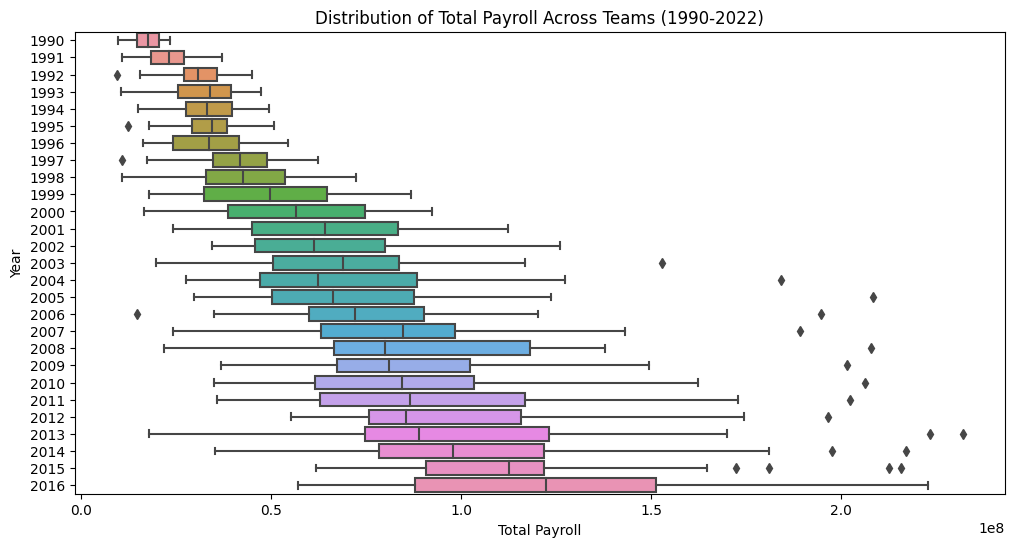

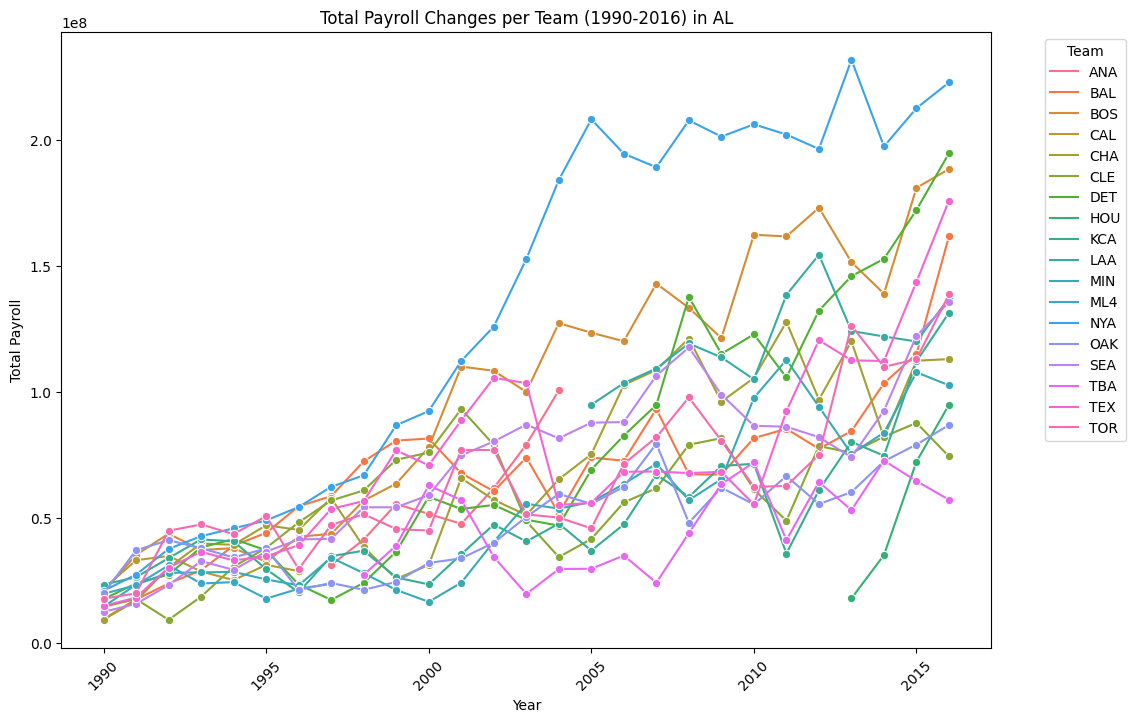

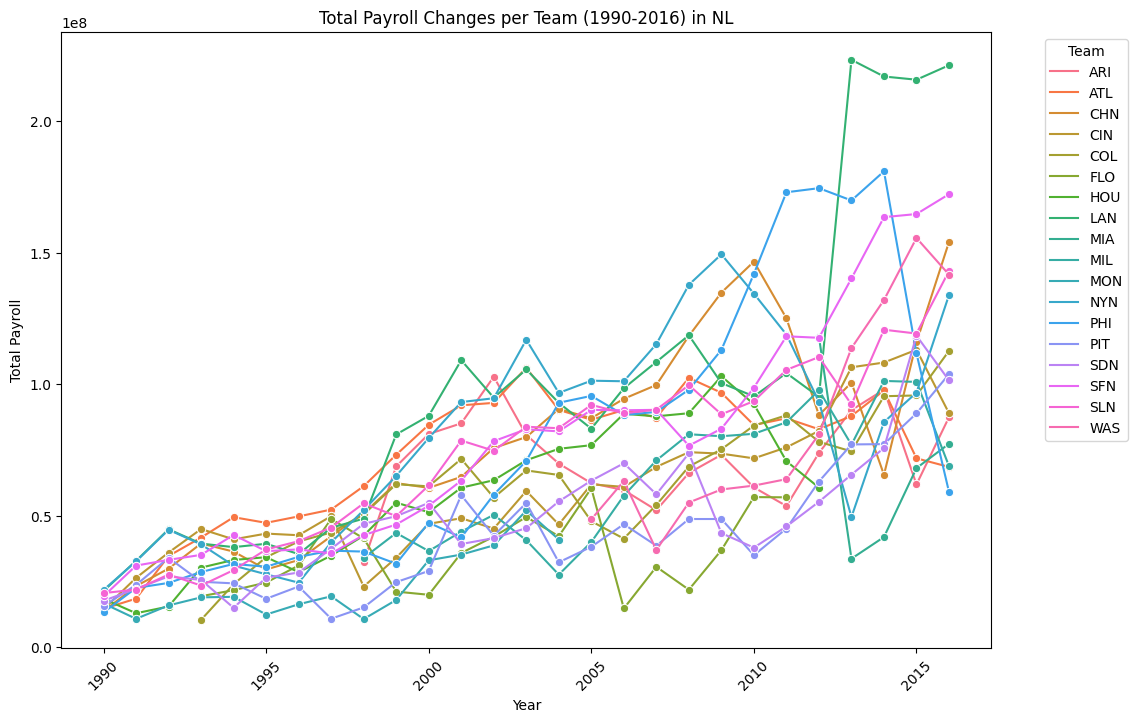

In [10]:
# This code will narrow down salWL to just 1990 - 2016 and then make a box plot of
# the total payroll distributions for the teams by year
salWL_90_16 = salWL[(salWL["yearID"] >= 1990) & (salWL["yearID"] <= 2016)]

# Plotting
plt.figure(figsize=(12, 6))
sns.boxplot(y="yearID", x="total_payroll", data=salWL_90_16, orient="h")
plt.title("Distribution of Total Payroll Across Teams (1990-2022)")
plt.ylabel("Year")
plt.xlabel("Total Payroll")
plt.show()

# this next plot will show a line graph of how each teams payroll
# changes through the years
# Get unique lgID values
unique_lgIDs = salWL_90_16["lgID"].unique()

# Create a line plot for each lgID
for lgID in unique_lgIDs:
    plt.figure(figsize=(12, 8))
    # Filter data for the specific lgID
    data_filtered = salWL_90_16[salWL_90_16["lgID"] == lgID]
    sns.lineplot(
        data=data_filtered, x="yearID", y="total_payroll", hue="teamID", marker="o"
    )
    plt.title(f"Total Payroll Changes per Team (1990-2016) in {lgID}")
    plt.xlabel("Year")
    plt.ylabel("Total Payroll")
    plt.xticks(rotation=45)
    plt.legend(title="Team", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

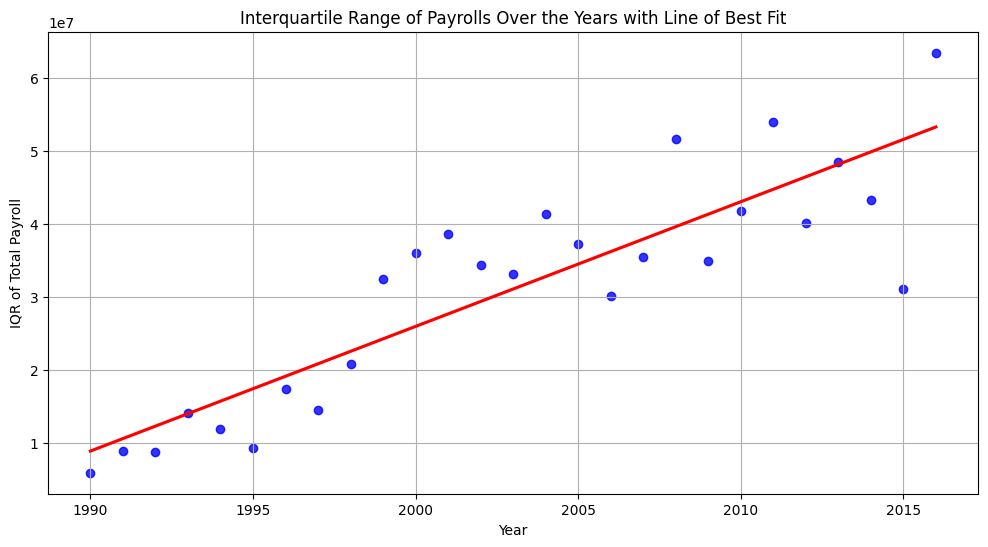

In [11]:
# Question 1
# What statements can you make about the distribution of payrolls conditioned on
# time based on these plots? Remember you can make statements in terms of
# central tendency, spread, etc.

# From the data, we see that the New York Yankees payroll is consisently high
# which gives some validation to why theyre known as the most heavily
# funded baseball team.
# We see that as years progress, the average has continued to increase. That's to be
# expected but what is worthy of note is that we have more and more outliers as the
# years have gone on. Of 22 outliers, 18 are in the later 13 years opposed
# to the first 13
# This indicates that the spread is growing each year and that the central tendency
# is decreasing.
# Basically, the distribution of payrolls is becoming less and less fair in baseball
# as time goes on. So it's no suprise that there has been some pushes to cap
# the amount of money a team can use.

# Problem 3
# Write code to produce plots that specifically show at least one of the statements
# you made in Question 1. For example, if you make a statement that there is a
# trend for payrolls to decrease over time, make a plot of a statistic for
# central tendency (e.g., mean payroll) vs. time to show that specficially.

# The previous plots have kinda already done this but I'll go ahead and make a graph
# just showing that the IQR(interquartile range) is growing over the years
iqr_data = salWL_90_16.groupby("yearID")["total_payroll"].agg(
    lambda x: x.quantile(0.75) - x.quantile(0.25)
)

# Creating a DataFrame from the IQR
iqr_df = pd.DataFrame({"yearID": iqr_data.index, "IQR": iqr_data.values})

# Creating the line plot
plt.figure(figsize=(12, 6))
#adding in a line of best fit
sns.regplot(
    x="yearID",
    y="IQR",
    data=iqr_df,
    ci=None,
    scatter_kws={"color": "blue"},
    line_kws={"color": "red"},
)
plt.title("Interquartile Range of Payrolls Over the Years with Line of Best Fit")
plt.xlabel("Year")
plt.ylabel("IQR of Total Payroll")
plt.grid(True)
plt.show()

<ipython-input-12-6c92954fbdb4>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salWL_90_16.loc[:, "time_period"] = pd.cut(
<ipython-input-12-6c92954fbdb4>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salWL_90_16.dropna(subset=["total_payroll", "win_perc"], inplace=True)


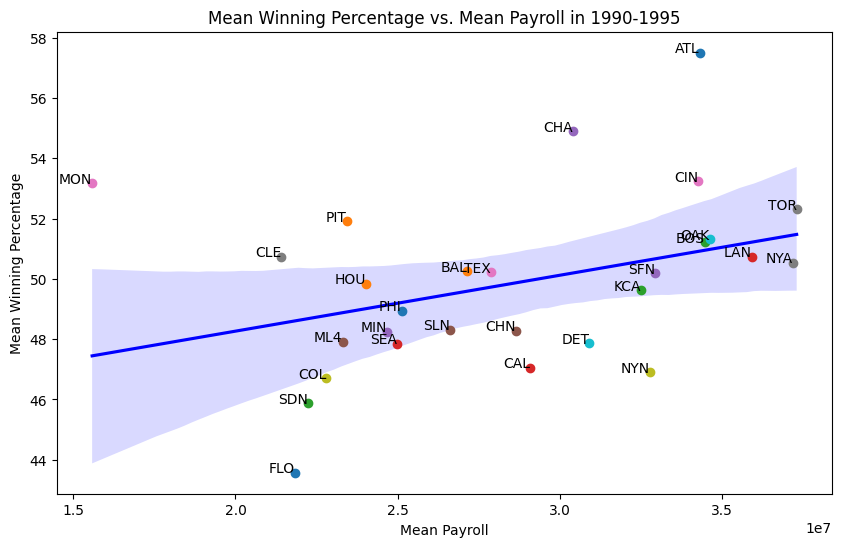

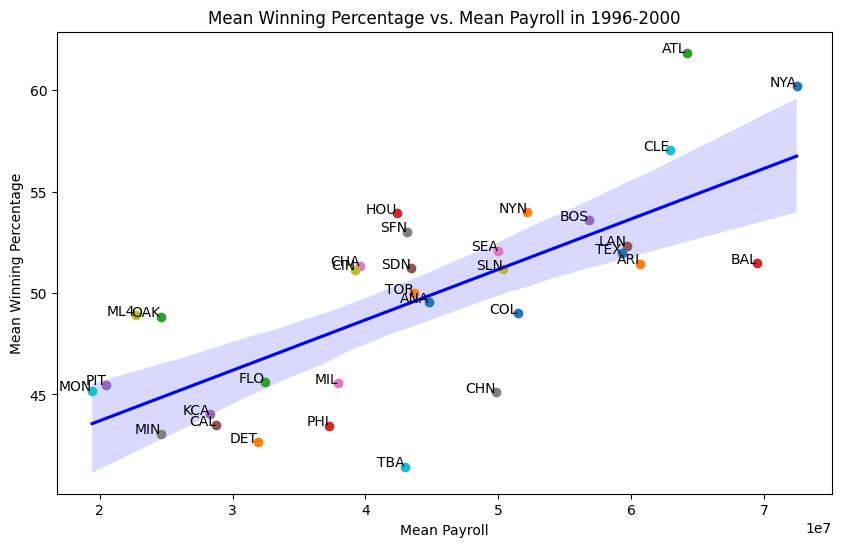

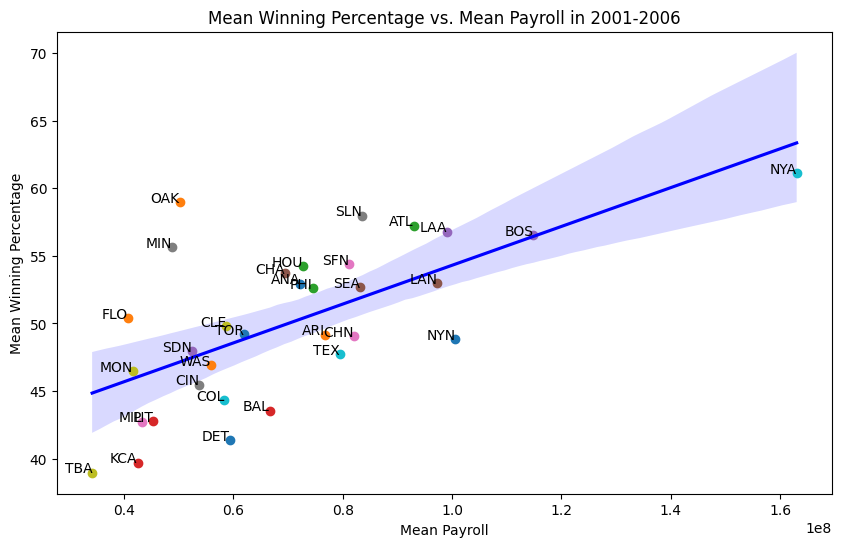

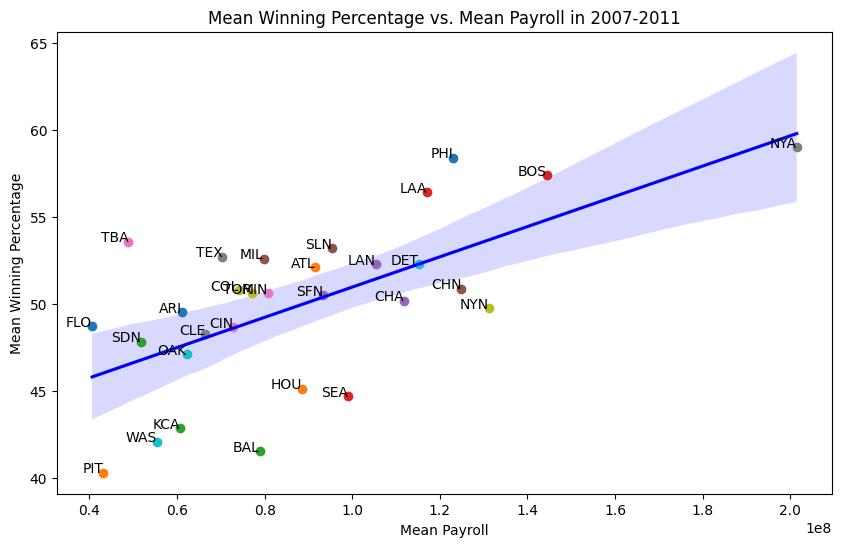

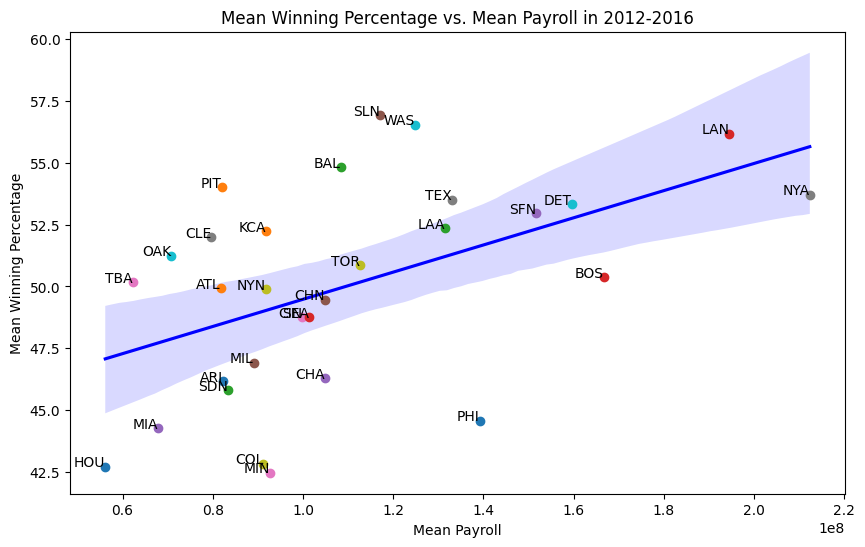

In [12]:
# Correlation between payroll and winning percentage
# Problem 4
# Write code to discretize year into five time periods
# (you can use pandas.cut to accomplish this)
# and then make a scatterplot showing mean winning percentage (y-axis) vs.
# mean payroll (x-axis) for each of the five time periods.
# You could add a regression line (using, e.g., NumPy's polyfit)
# in each scatter plot to ease interpretation.

# we have the years from 1990 to 2016 and we want to split it up into 5 time periods
# settting precision to 0 since we don't have month values
time_periods = pd.cut(range(1990, 2017), bins=5, precision=0)

# from this we can see that the the time periods are
# 1 = 1990 - 1995 (5 years)
# 2 = 1996 - 2000 (4 years)
# 3 - 2001 - 2006 (5 years)
# 4 = 2007 - 2011 (4 years)
# 5 = 2012 - 2016 (4 years)
# So it's not a perfect split but it couldn't be since we don't have data for 2017-2022
# print(time_periods)


# Plotting the average payroll and winning percentage by bins of years
bin_edges = [1990, 1996, 2001, 2007, 2012, 2017]
labels = ["1990-1995", "1996-2000", "2001-2006", "2007-2011", "2012-2016"]
salWL_90_16.loc[:, "time_period"] = pd.cut(
    salWL_90_16["yearID"], bins=bin_edges, labels=labels, right=False, precision=0
)


# taking just the non missing numbers
salWL_90_16.dropna(subset=["total_payroll", "win_perc"], inplace=True)
salWL_90_16 = salWL_90_16[
    (pd.notnull(salWL_90_16["total_payroll"])) & (pd.notnull(salWL_90_16["win_perc"]))
]

# Grouping by time periods and teamID
grouped_data = (
    salWL_90_16.groupby(["time_period", "teamID"])
    .agg({"total_payroll": "mean", "win_perc": "mean"})
    .reset_index()
)

# Loop through each time period to create individual plots
for period in grouped_data["time_period"].unique():
    plt.figure(figsize=(10, 6))
    period_data = grouped_data[grouped_data["time_period"] == period]

    # Plot with line of best fit
    sns.regplot(
        x="total_payroll", y="win_perc", data=period_data, scatter=False, color="blue"
    )

    # Add scatter points and labels for each point
    for index, row in period_data.iterrows():
        if pd.notnull(row["total_payroll"]) and pd.notnull(row["win_perc"]):
            plt.scatter(row["total_payroll"], row["win_perc"], label=row["teamID"])
            plt.text(
                row["total_payroll"],
                row["win_perc"],
                row["teamID"],
                horizontalalignment="right",
            )

    plt.xlabel("Mean Payroll")
    plt.ylabel("Mean Winning Percentage")
    plt.title(f"Mean Winning Percentage vs. Mean Payroll in {period}")
    plt.show()

In [ ]:
# Question 2
# What can you say about team payrolls across these periods? Are there any teams that
# standout as being particularly good at paying for wins across these time periods?
# What can you say about the Oakland A's spending efficiency across these time periods
# (labeling points in the scatterplot can help interpretation).


# Across all time periods, mean winning percentage increased (on average) with an
# increase in mean payroll.
#
# What I didn't expect, but was proven by Moneyball, is that money must not be the only
# factor since the NY Yankees (NYA) are consistently a well funded baseball team but
# they're also consistently beaten or tied for best winning percentage with teams that
# are far less funded. Even in the more recent years of 2012-2016.
#
# It's hard to see from these graphs if there is a team that
# were consistently good with less money. The mean payroll fluctuates a lot for teams
# between the bins of years.If I had to pick one, the ATL Atlanta Braves were good
# with high funding and they've consistently been above the line of best fit for all
# but the most recent bin
#
# Oakland was an anomaly during moneyball in 2002 and it shows in that time period
# with a mean winning percentage that rivals the top funded teams in that bucket
# of years. It's pretty incredible that math changed the baseball game that year.
# They competed with the NY Yankees as far as mean winning percentage,
# with a payroll that was a third of the size

In [13]:
# Part 3: Data transformations
# Standardizing across years
# It looks like comparing payrolls across years is problematic so let's do a
# transformation that will help with these comparisons.

# Problem 5
# Create a new variable in your dataset that standardizes payroll conditioned on year.
# So, this column for team i in year j should equal:
# standardized_payroll_ij = (payroll_ij - avg_payroll_j)/s_j
# for team i in year j.

# where avg_payrollj is the average payroll for year j, and sj is the standard
# deviation of payroll for year j.

#get the yearly stats of mean and standard deviation by year
yearly_stats = (
    salWL_90_16.groupby("yearID")["total_payroll"].agg(["mean", "std"]).reset_index()
)
#rename the mean column to avg_payroll and the std column to std_dev
yearly_stats.rename(columns={"mean": "avg_payroll", "std": "std_dev"}, inplace=True)

# merge these stats back into the original df
salWL_90_16 = pd.merge(salWL_90_16, yearly_stats, on="yearID")

# find the standardized payroll
salWL_90_16["standardized_payroll"] = (
    salWL_90_16["total_payroll"] - salWL_90_16["avg_payroll"]
) / salWL_90_16["std_dev"]

# printing some years to have a look at the data
print(salWL_90_16[salWL_90_16["yearID"] == 1990].head())
print(salWL_90_16[salWL_90_16["yearID"] == 1998].head())

    teamID  yearID  Wins  Losses  total_payroll  win_perc lgID time_period  \
598    ATL    1990    65      97    14555501.00     40.12   NL   1990-1995   
599    BAL    1990    76      85     9680084.00     47.20   AL   1990-1995   
600    BOS    1990    88      74    20558333.00     54.32   AL   1990-1995   
601    CAL    1990    80      82    21720000.00     49.38   AL   1990-1995   
602    CHA    1990    94      68     9491500.00     58.02   AL   1990-1995   

     avg_payroll    std_dev  standardized_payroll  
598  17072353.58 3771834.26                 -0.67  
599  17072353.58 3771834.26                 -1.96  
600  17072353.58 3771834.26                  0.92  
601  17072353.58 3771834.26                  1.23  
602  17072353.58 3771834.26                 -2.01  
   teamID  yearID  Wins  Losses  total_payroll  win_perc lgID time_period  \
28    ANA    1998    85      77    41281000.00     52.47   AL   1996-2000   
29    ARI    1998    65      97    32347000.00     40.12   NL   1

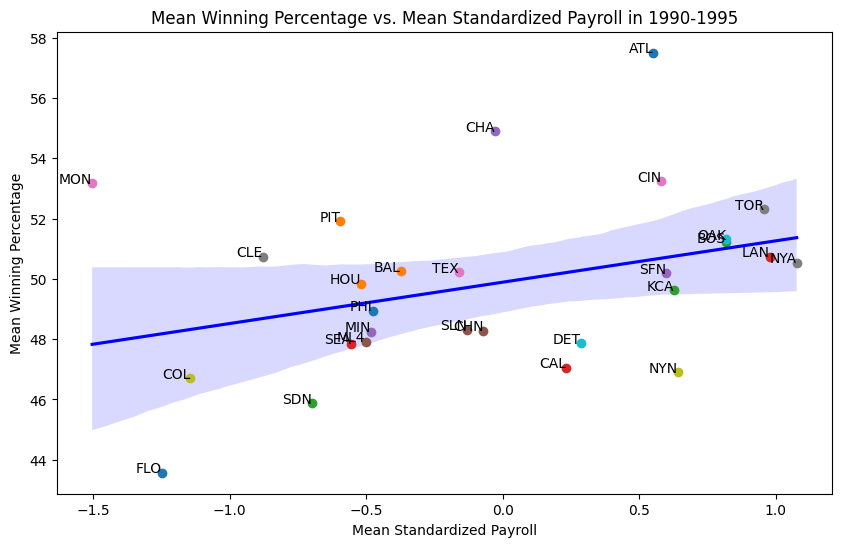

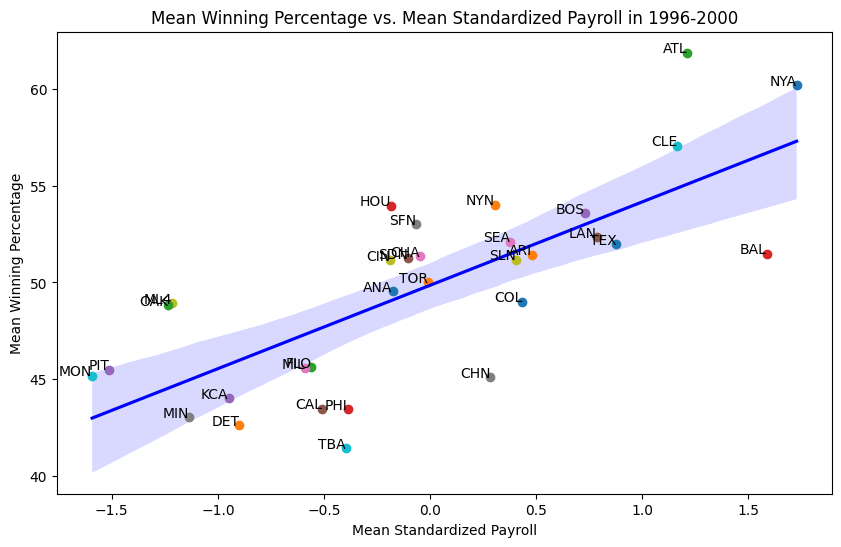

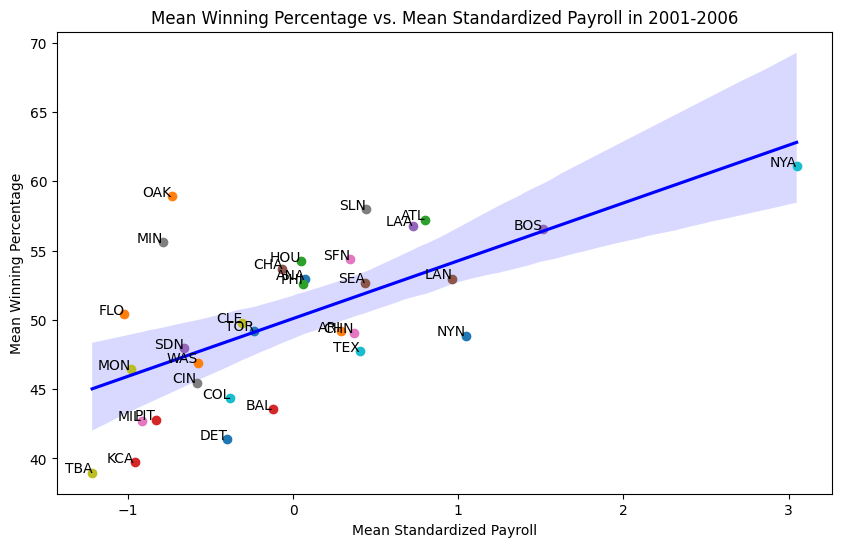

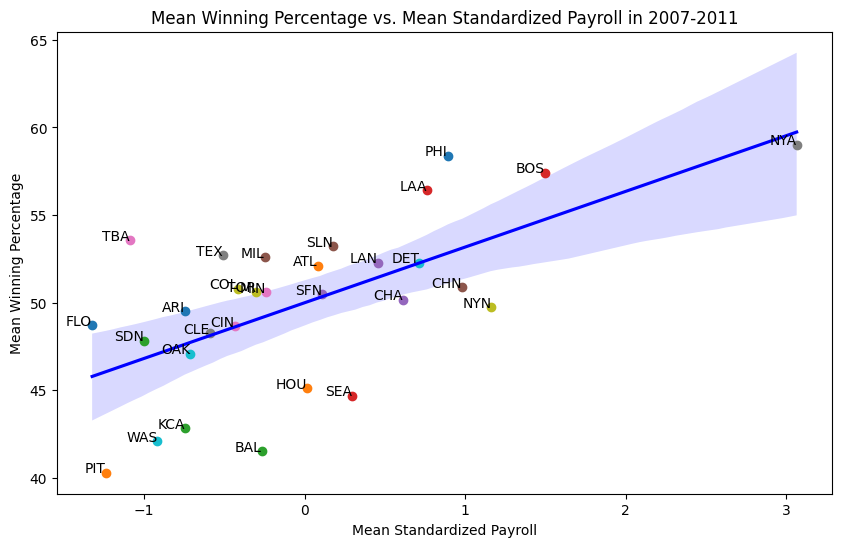

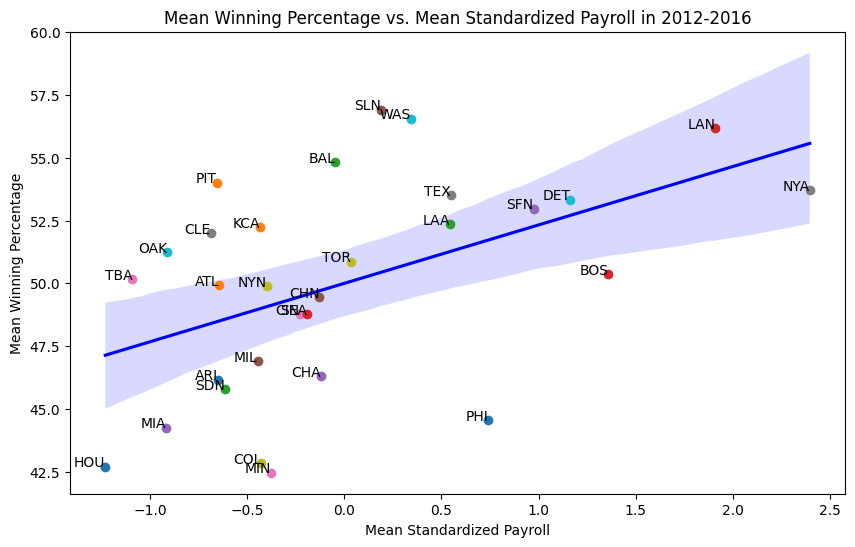

In [14]:
# Problem 6
# Repeat the same plots as Problem 4, but use this new standardized payroll variable.

# grouping by time periods and teamID
grouped_data = (
    salWL_90_16.groupby(["time_period", "teamID"])
    .agg({"standardized_payroll": "mean", "win_perc": "mean"})
    .reset_index()
)


# loop through each time period to create individual plots
for period in grouped_data["time_period"].unique():
    plt.figure(figsize=(10, 6))
    period_data = grouped_data[grouped_data["time_period"] == period]
    sns.regplot(
        x="standardized_payroll",
        y="win_perc",
        data=period_data,
        scatter=False,
        color="blue",
    )

    # add scatter points and labels for each point
    for index, row in period_data.iterrows():
        if pd.notnull(row["standardized_payroll"]) and pd.notnull(row["win_perc"]):
            plt.scatter(
                row["standardized_payroll"], row["win_perc"], label=row["teamID"]
            )
            plt.text(
                row["standardized_payroll"],
                row["win_perc"],
                row["teamID"],
                horizontalalignment="right",
            )

    plt.xlabel("Mean Standardized Payroll")
    plt.ylabel("Mean Winning Percentage")
    plt.title(f"Mean Winning Percentage vs. Mean Standardized Payroll in {period}")
    plt.show()

In [ ]:
# Question 3
# Discuss how the plots from Problem 4 and Problem 6 reflect the transformation you did
# on the payroll variable.

# The transformation makes it really easy to compare the payrolls of teams
# For example, we can see in the moneyball bucket (2001-2006) that the oakland A's
# we're at almost a 1 standard deviation disadvantage in mean payroll but competed
# against the NY Yankees who were at 3 standard deviation advantage.

# Another observation that I'm now seeing is that our line of best fit had a smaller
# slope in the first and last buckets. This is an indicator that the mean
# standardized payroll had more of an influence on the mean winning percentage
# in the middle buckets of years

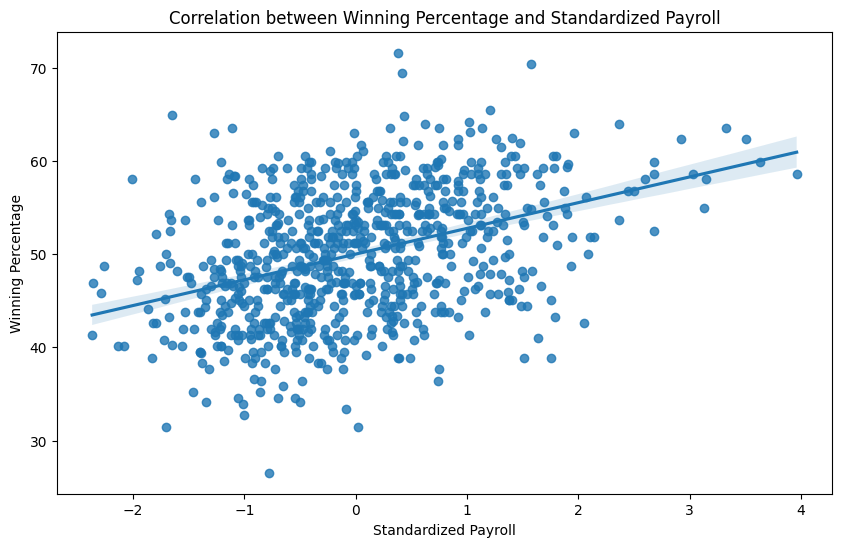

In [15]:
# Expected wins
# It's hard to see global trends across time periods using these multiple plots, but
# now that we have standardized payrolls across time, we can look at a single plot
# showing correlation between winning percentage and payroll across time.

# Problem 7
# Make a single scatter plot of winning percentage (y-axis) vs. standardized payroll
# (x-axis). Add a regression line to highlight the relationship.

plt.figure(figsize=(10, 6))
sns.regplot(x="standardized_payroll", y="win_perc", data=salWL_90_16)

plt.xlabel("Standardized Payroll")
plt.ylabel("Winning Percentage")
plt.title("Correlation between Winning Percentage and Standardized Payroll")
plt.show()

In [16]:
# The regression line gives you expected winning percentage as a function of
# standardized payroll. Looking at the regression line, it looks like teams that
# spend roughly the average payroll in a given year will win 50% of their games
# (i.e. win_pct is 50 when standardized_payroll is 0), and teams increase 5% wins
# for every 2 standard units of payroll (i.e., win_pct is 55 when standardized_payroll
# is 2). We will see how this is done in general using linear regression
# later in the course.

# From these observations we can calculate the expected win percentage for
# team i in year j as
# expected_win_pct_ij = 50 + 2.5 * standardized_payroll_ij
salWL_90_16["expected_win_pct"] = 50 + 2.5 * salWL_90_16["standardized_payroll"]


# Spending efficiency
# Using this result, we can now create a single plot that makes it easier to
# compare teams efficiency. The idea is to create a new measurement unit for
# each team based on their winning percentage and their expected winning percentage
# that we can plot across time summarizing how efficient each team is in their spending.

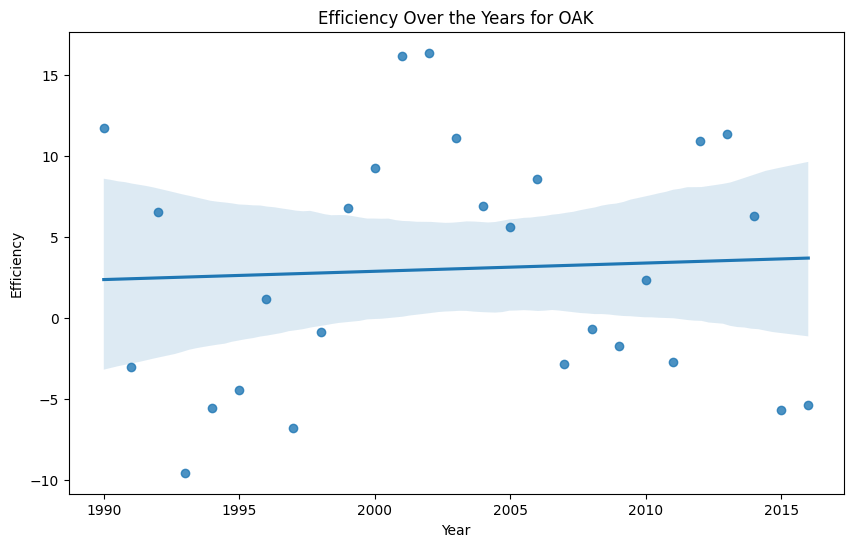

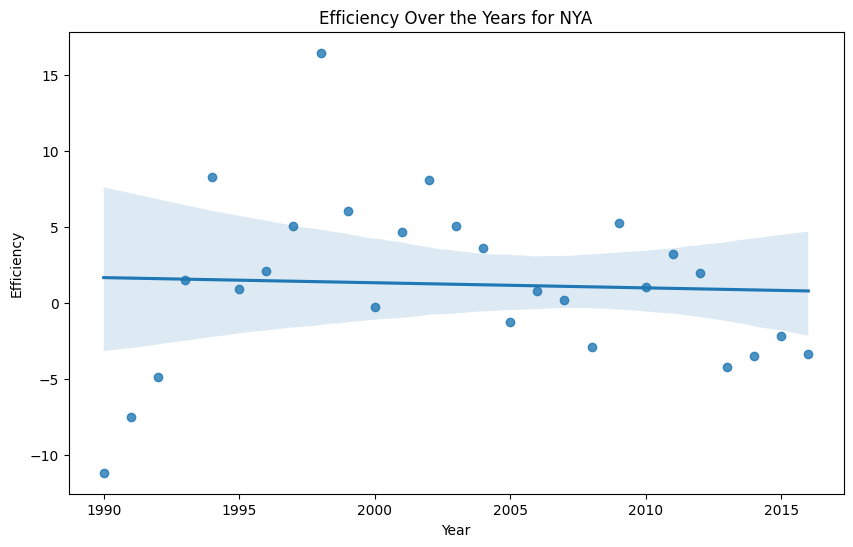

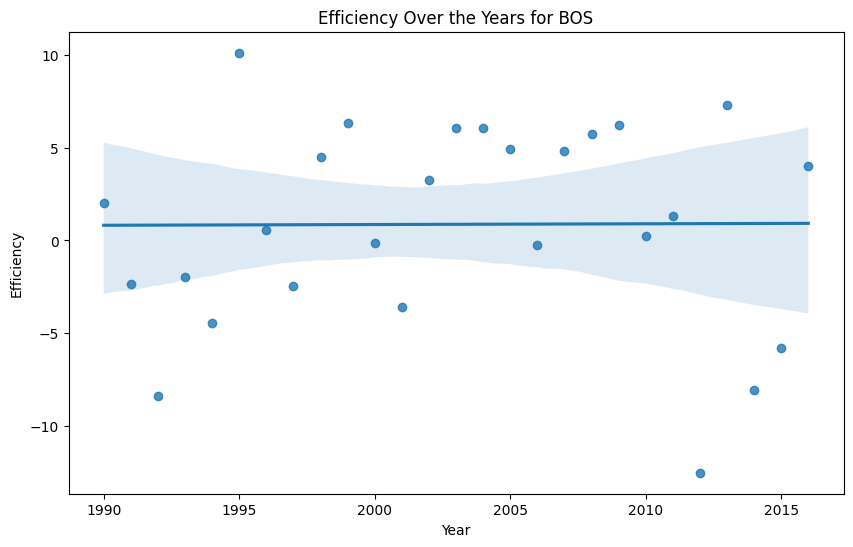

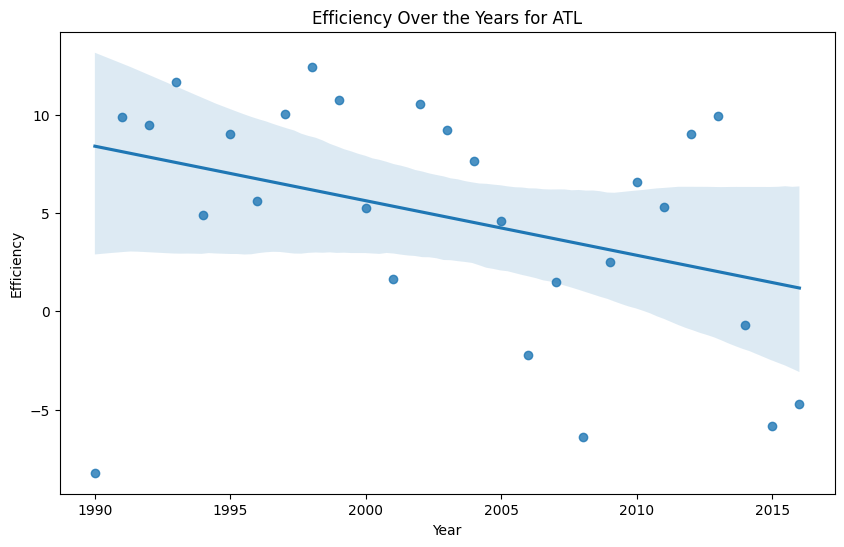

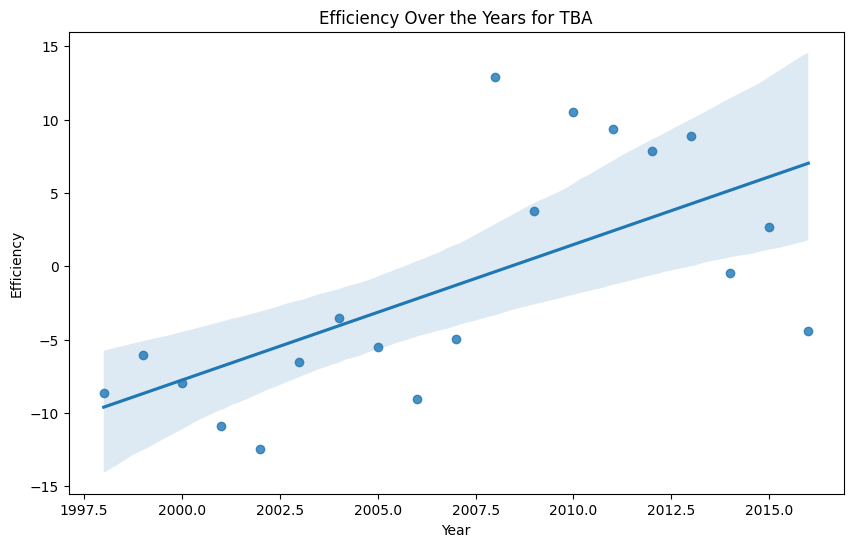

In [17]:
# Problem 8
# Create a new field to compute each team's spending effiency, given by
# efficiency_ij = win_pct_ij - expected_win_pct_ij
# or team i in year j, where expected_win_pct is given above.

#getting the efficiency column based on the formula
salWL_90_16["efficiency"] = salWL_90_16["win_perc"] - salWL_90_16["expected_win_pct"]


# Make a line plot with year on the x-axis and efficiency on the y-axis.
# A good set of teams to plot are Oakland, the New York Yankees, Boston, Atlanta and
# Tampa Bay (teamIDs OAK, BOS, NYA, ATL, TBA).

# filter for the specified teams
teams = ["OAK", "NYA", "BOS", "ATL", "TBA"]
filtered_data = salWL_90_16[salWL_90_16["teamID"].isin(teams)]

# Creating individual plots with a line of best fit for each team
for team in teams:
    plt.figure(figsize=(10, 6))
    team_data = filtered_data[filtered_data["teamID"] == team]
    sns.regplot(x="yearID", y="efficiency", data=team_data)
    plt.xlabel("Year")
    plt.ylabel("Efficiency")
    plt.title(f"Efficiency Over the Years for {team}")
    plt.show()

In [ ]:
# Question 4
# What can you learn from this plot compared to the set of plots you looked at in
# Question 2 and 3? How good was Oakland's efficiency during the Moneyball period?

# It's interesting because Oaklands efficiency, while phenomenal, was actually rivaled
# one year by the New York Yankees. I'm pretty impressed with Tampa Bay's increase in
# efficiency over the years. I added the line of best fit to see if teams are getting
# more or less efficient as the years go by. Atlanta has gotten worse and worse as the
# years have gone on.